In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
from scipy.stats import ttest_ind

In [86]:
# Тянем интересующий фрейм из кликхауса прямым запросом
connection = {
    'host': 'https://clickhouse',
    'password': 'pass',
    'user': 'user',
    'database': 'db'
}

q = '''
SELECT 
user_id,
exp_group,
countIf(action, action='like') as likes,
countIf(action, action='view') as views,
countIf(action, action='like')/countIf(action, action='view') as CTR

FROM simulator_20230820.feed_actions 
WHERE 
toDate(time) >= '2023-07-30' and toDate(time) <= '2023-08-05'
GROUP BY
user_id, exp_group
'''

df_users = pandahouse.read_clickhouse(q, connection=connection) 

In [87]:
# Смотрим что вытянули

df_users

,user_id,exp_group,likes,views,CTR
0,18392,1,7,32,0.218750
1,115383,3,12,44,0.272727
2,123580,3,2,11,0.181818
3,131473,2,9,108,0.083333
4,107323,4,5,31,0.161290
...,...,...,...,...,...
49809,27030,0,12,64,0.187500
49810,122758,3,20,118,0.169492
49811,132567,1,52,326,0.159509
49812,122190,3,19,65,0.292308


<b>Задача</b>

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [88]:
group_0 = df_users[df_users['exp_group'] == 0]
group_1 = df_users[df_users['exp_group'] == 1]
group_2 = df_users[df_users['exp_group'] == 2]
group_3 = df_users[df_users['exp_group'] == 3]
group_0.name = 'Группа 0'
group_1.name = 'Группа 1'
group_2.name = 'Группа 2'
group_3.name = 'Группа 3'

In [89]:
# Сразу делаем большие графики
sns.set (rc={"figure.figsize":( 12 , 10 )})

---------------------

<h4> Проведем классический Т-тест между группами 0 и 3 а также 1 и 2</h4>

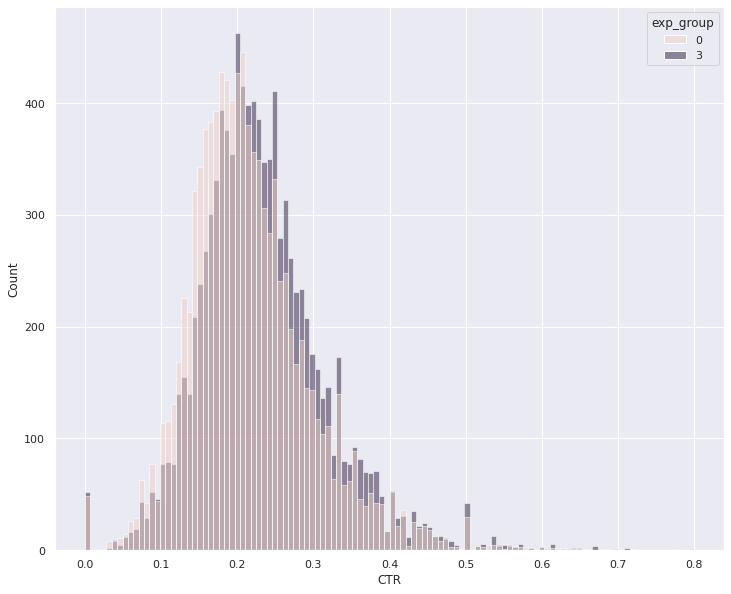

In [90]:
# Посмотрим на группы 0 и 3
sns.histplot(data=df_users[df_users['exp_group'].isin((0, 3))], x='CTR', hue='exp_group')
plt.show()

In [91]:
# Т-тест групп 0 и 3

result_0_3 = ttest_ind(group_0['CTR'], group_3['CTR'])
result_0_3

Ttest_indResult(statistic=-13.933648837791845, pvalue=6.360547724658604e-44)

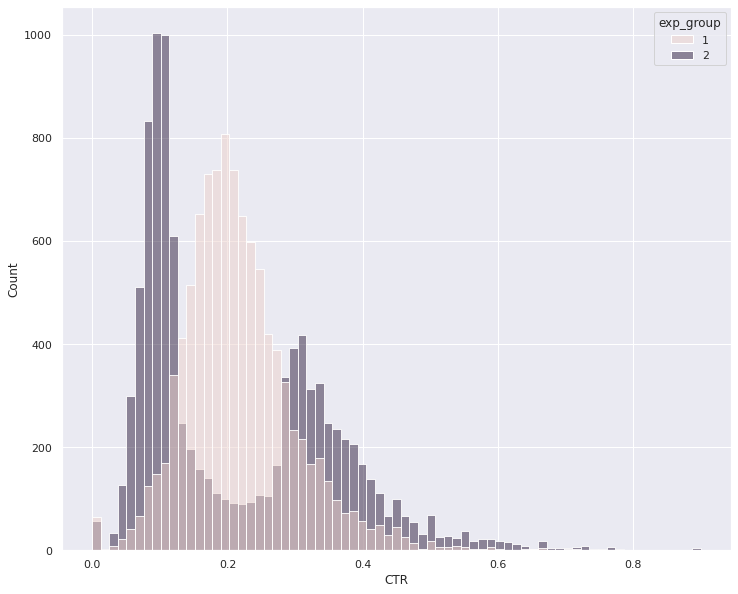

In [92]:
# Посмотрим на группы 1 и 2
sns.histplot(data=df_users[df_users['exp_group'].isin((1, 2))], x='CTR', hue='exp_group')
plt.show()

In [93]:
# Т-тест групп 1 и 2

result_1_2 = ttest_ind(group_1['CTR'], group_2['CTR'])
result_1_2

Ttest_indResult(statistic=0.4065949741045715, pvalue=0.6843098628062774)

In [94]:
# Итоговый сравнительный отчет уровня значимости

result_frame = pd.DataFrame((result_0_3, result_1_2), index=['0-3: classic T', '1-2: classic T'])

In [95]:
result_frame

,statistic,pvalue
0-3: classic T,-13.933649,6.360548e-44
1-2: classic T,0.406595,6.843099e-01


------------------

In [110]:
# класс - преобразователь данных по методу линеаризованных лайков

class MyLinearized:
    def __init__(self):
        self.data_test = None
        self.data_control = None
        self.data_out = []
    
    def __repr__(self):
        return f'''Linearized преобразование:
        Входные данные: {[x.name for x in self.data]}'''
    
    
    def load_data(self, data_test, data_control):
        self.data_test = data_test.copy()
        self.data_control = data_control.copy()
        
    def transform(self):
        global_ctr_control = sum(self.data_control['likes']) / sum(self.data_control['views'])
        self.data_test['Linearized_likes'] = self.data_test['likes'] - self.data_test['views'] * global_ctr_control
        self.data_control['Linearized_likes'] = self.data_control['likes'] - self.data_control['views'] * global_ctr_control
        self.data_out.append(pd.concat([self.data_test, self.data_control]))
        
    def get_data(self):
        return self.data_out

In [111]:
# Создаем экземпляр преобразователя
linear_me = MyLinearized()

# Грузим данные 1 и 2
linear_me.load_data(group_2, group_1)

# Запускаем шарманку
linear_me.transform()

# Грузим данные 0 и 3
linear_me.load_data(group_3, group_0)

# Запускаем шарманку
linear_me.transform()

# Сохраняем итоги
data_linearized_1_2 = linear_me.get_data()[0]
data_linearized_0_3 = linear_me.get_data()[1]

In [118]:
# Смотрим что вышло
data_linearized_1_2.head()

,user_id,exp_group,likes,views,CTR,Linearized_likes
3,131473,2,9,108,0.083333,-13.637250
5,32420,2,13,44,0.295455,3.777417
6,24239,2,40,90,0.444444,21.135625
16,118619,2,8,65,0.123077,-5.624271
19,10098,2,3,9,0.333333,1.113563


In [119]:
data_linearized_0_3.head()

,user_id,exp_group,likes,views,CTR,Linearized_likes
1,115383,3,12,44,0.272727,2.767128
2,123580,3,2,11,0.181818,-0.308218
9,118359,3,7,38,0.184211,-0.973844
12,16699,3,6,16,0.375000,2.642592
14,138445,3,18,93,0.193548,-1.514933


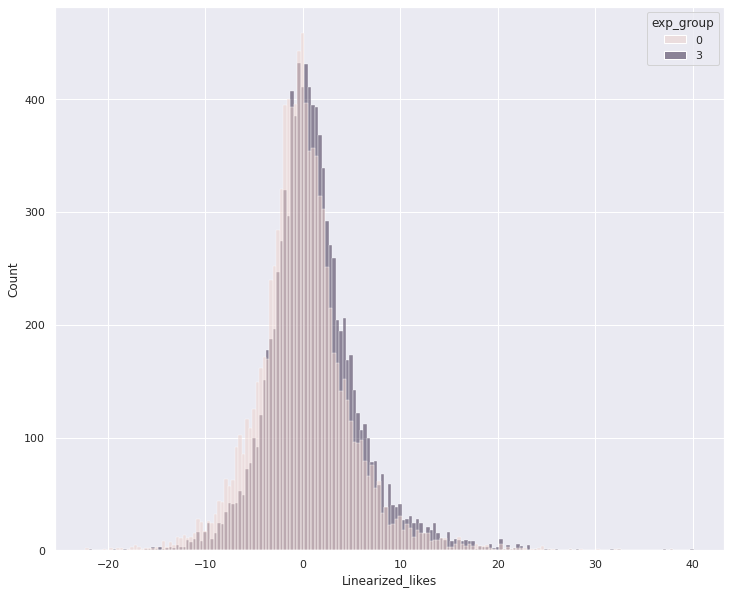

In [120]:
# Посмотрим на лин. лайки группы 0 и 3
sns.histplot(data=data_linearized_0_3, x='Linearized_likes', hue='exp_group')
plt.show()

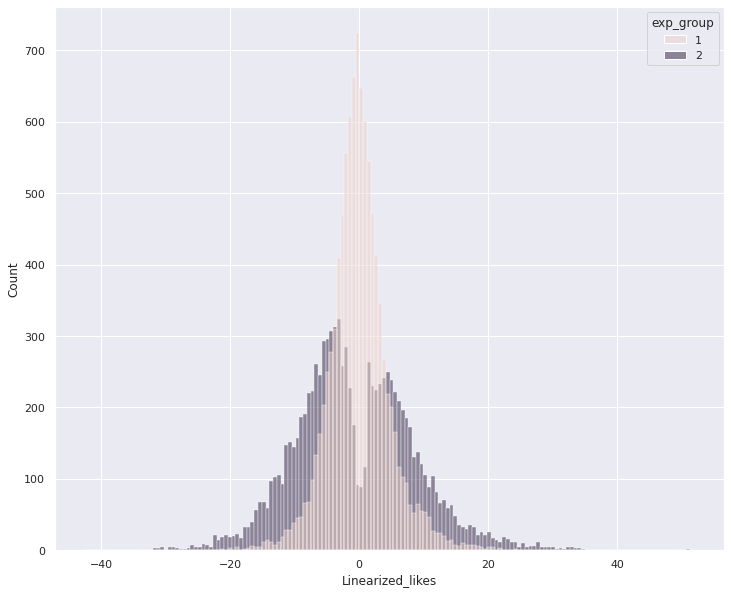

In [121]:
# Посмотрим на лин. лайки группы 1 и 2
sns.histplot(data=data_linearized_1_2, x='Linearized_likes', hue='exp_group')
plt.show()

In [122]:
# разобьем по группам
group_0_lin = data_linearized_0_3[data_linearized_0_3['exp_group'] == 0]
group_1_lin = data_linearized_1_2[data_linearized_1_2['exp_group'] == 1]
group_2_lin = data_linearized_1_2[data_linearized_1_2['exp_group'] == 2]
group_3_lin = data_linearized_0_3[data_linearized_0_3['exp_group'] == 3]

In [126]:
# Т-тест групп 1 и 2

result_1_2_lin = ttest_ind(group_1_lin['Linearized_likes'], group_2_lin['Linearized_likes'])
result_1_2_lin

# Т-тест групп 0 и 3

result_0_3_lin = ttest_ind(group_0_lin['Linearized_likes'], group_3_lin['Linearized_likes'])
result_0_3_lin

# Вносим все в финальный отчет
final_report = pd.concat([result_frame, pd.DataFrame([result_0_3_lin, result_1_2_lin], index = ['0-3: linearized likes T', '1-2: linearized likes T'])])

In [127]:
# Смотрим что вышло
final_report

,statistic,pvalue
0-3: classic T,-13.933649,6.360548e-44
1-2: classic T,0.406595,6.843099e-01
0-3: linearized likes T,-16.186959,1.474003e-58
1-2: linearized likes T,5.962012,2.533570e-09


<h4>Выводы:</h4>

>1. На наборах данных 0 - 3 классический Т-тест находил стат. значимые отличия. После линеаризации лайков, p - value еще сильнее уменьшился, показав еще значимеей различия. Интересно, что характер изменения можно посмотреть по знаку среднего значения.

In [131]:
# Положительное значение - улучшающий характер изменения от контрольной группы
group_3_lin['Linearized_likes'].mean()

1.0948439641134204

>2. На наборах данных 1 - 2 классический Т-тест не находил стат. значимые различия. После линеаризации лайков, p - value опустился на 8 порядков и показал стат. значимые различия. Характер изменения можно посмотреть по знаку среднего значения тестовой группы.

In [132]:
# Отрицательное значение - ухудшающий характер изменения от контрольной группы
group_2_lin['Linearized_likes'].mean()

-0.6245118559393541

-----------